In [21]:
"""Run the MapScore.ipynb to calculate the map score"""
%run MapSocre.ipynb

In [4]:
# importing the neccesary lib
import os , cv2 , glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet # importing xml.etree for reading the xml files

# importing tensorflow libraries
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152V2 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [22]:
annotation_path = './VOC2007/Annotations/' # base directory for xml files

xmls = glob.glob(f'{annotation_path}/*.xml') # load all the xml files 

df= dict(filepath=[],img_path=[],xmin=[],xmax=[],ymin=[],ymax=[])#dictionary containing xml & coresponding image info


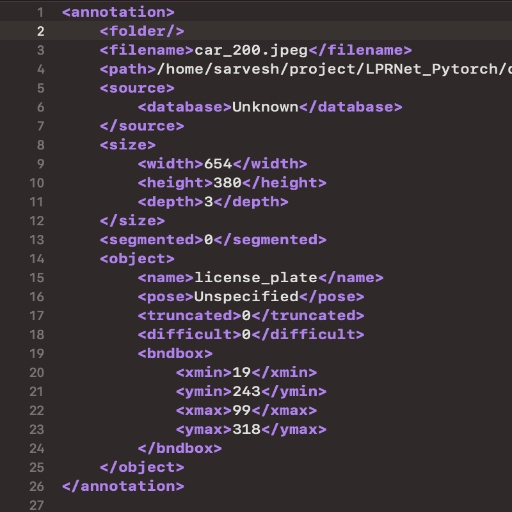

In [23]:
path = glob.glob('./VOC2007/Annotations/*.xml') # load all the .xml files 

labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[]) # labels_dict will store the dataset
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [24]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./VOC2007/Annotations/car_499.xml,243,285,184,204
1,./VOC2007/Annotations/car_328.xml,269,317,170,189
2,./VOC2007/Annotations/car_314.xml,229,309,151,178
3,./VOC2007/Annotations/car_472.xml,152,247,145,167
4,./VOC2007/Annotations/car_466.xml,253,284,163,177


#### We will be using the pretrained model Resnet150V2 for predicting the four points which will create the bounding box 

In [32]:
filename = df['filepath'][0]
"""getFilename function will change the xml file dir to corresponding image file dir"""
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text # get the corresponding image dir 
    # replace Annotations with JPEGImages and jpeg with jpg
    filepath_image = os.path.join('./VOC2007/JPEGImages',filename_image.replace('jpeg','jpg'))
    return filepath_image
getFilename(filename)

'./VOC2007/JPEGImages/car_499.jpg'

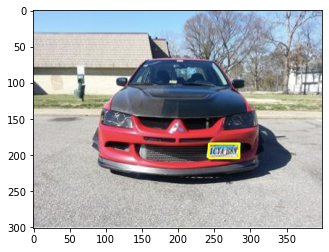

In [33]:
xmin,xmax,ymin,ymax = df['xmin'][0] , df['xmax'][0],df['ymin'][0],df['ymax'][0] # get the coordinate of the box
# draw a yellow colored rectangle of thickness 3 
image = cv2.rectangle(plt.imread(getFilename(df['filepath'][0])),(xmin,ymin),(xmax,ymax),(255,255,0),2)
plt.imshow(image)

In [34]:
"""imagepath will store the jpg image dir"""
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['./VOC2007/JPEGImages/car_499.jpg',
 './VOC2007/JPEGImages/car_328.jpg',
 './VOC2007/JPEGImages/car_314.jpg',
 './VOC2007/JPEGImages/car_472.jpg',
 './VOC2007/JPEGImages/car_466.jpg',
 './VOC2007/JPEGImages/car_300.jpg',
 './VOC2007/JPEGImages/car_658.jpg',
 './VOC2007/JPEGImages/car_116.jpg',
 './VOC2007/JPEGImages/car_102.jpg',
 './VOC2007/JPEGImages/car_664.jpg']

We will preprocess the image before feeding it to the model , preprocessing wil consist of ,
1. Divinding the image by 255.0 (min-max scaling)
2. since the diving the pixels value will afftect the real rectangular points , we will divide the coordinate points 
by width and height , as it will normalize them with respect to the bix dimensions
3. Divide the dataset into train , val and test set


In [37]:
labels = df.iloc[:,1:].values
dataset = []
output = []
for ind in range(len(image_path)):
    img = cv2.imread(image_path[ind])
    h,w = img.shape[:2]
    
    img = cv2.resize(img,(224,224))
    norm_load_image_arr = img/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output

    dataset.append(norm_load_image_arr)
    output.append(label_norm)

In [40]:
# Convert data to array
X = np.array(dataset,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [41]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.85,random_state=42)
x_val = x_train[:30]
y_val = y_train[:30]
x_train = x_train[30:]
y_train = y_train[30:]

x_train.shape, x_test.shape,y_train.shape,y_test.shape , x_val.shape , y_val.shape

((538, 224, 224, 3),
 (101, 224, 224, 3),
 (538, 4),
 (101, 4),
 (30, 224, 224, 3),
 (30, 4))

In [42]:
# Using pretrained model , functional model is created , with 2 level of dense layer and a final output layer
resnet = ResNet152V2(weights="imagenet",include_top=False, input_shape=(224,224,3))
# ---------------------
headmodel = resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=resnet.input,outputs=headmodel)

Metal device set to: Apple M1


2022-08-08 20:49:16.859447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-08 20:49:16.860965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
# Complie model with mean squared error loss , adam optimiser
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_blo

                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
          

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
          

In [14]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=300,
                    validation_data=(x_test,y_test))

Epoch 1/300


2022-08-06 00:06:25.464148: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-06 00:06:31.834528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.0865

2022-08-06 00:08:51.763060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 157s 3s/step - loss: 0.0865 - val_loss: 0.0644
Epoch 2/300
54/54 [==============================] - 194s 3s/step - loss: 0.0145 - val_loss: 0.0177
Epoch 3/300
54/54 [==============================] - 78s 1s/step - loss: 0.0057 - val_loss: 0.0127
Epoch 4/300
54/54 [==============================] - 87s 2s/step - loss: 0.0049 - val_loss: 0.0111
Epoch 5/300
54/54 [==============================] - 199s 4s/step - loss: 0.0042 - val_loss: 0.0116
Epoch 6/300
54/54 [==============================] - 154s 3s/step - loss: 0.0035 - val_loss: 0.0096
Epoch 7/300
54/54 [==============================] - 170s 3s/step - loss: 0.0030 - val_loss: 0.0095
Epoch 8/300
54/54 [==============================] - 140s 3s/step - loss: 0.0026 - val_loss: 0.0087
Epoch 9/300
54/54 [==============================] - 164s 3s/step - loss: 0.0025 - val_loss: 0.0093
Epoch 10/300
54/54 [==============================] - 132s 2s/step - loss: 0.0022 - val_loss: 0.0090
Epoch 11/300


54/54 [==============================] - 77s 1s/step - loss: 8.1089e-04 - val_loss: 0.0065
Epoch 83/300
54/54 [==============================] - 75s 1s/step - loss: 9.3096e-04 - val_loss: 0.0072
Epoch 84/300
54/54 [==============================] - 79s 1s/step - loss: 9.1137e-04 - val_loss: 0.0064
Epoch 85/300
54/54 [==============================] - 78s 1s/step - loss: 8.5315e-04 - val_loss: 0.0064
Epoch 86/300
54/54 [==============================] - 77s 1s/step - loss: 8.3721e-04 - val_loss: 0.0065
Epoch 87/300
54/54 [==============================] - 74s 1s/step - loss: 8.1855e-04 - val_loss: 0.0064
Epoch 88/300
54/54 [==============================] - 76s 1s/step - loss: 7.5703e-04 - val_loss: 0.0065
Epoch 89/300
54/54 [==============================] - 74s 1s/step - loss: 7.5162e-04 - val_loss: 0.0063
Epoch 90/300
54/54 [==============================] - 73s 1s/step - loss: 7.3881e-04 - val_loss: 0.0063
Epoch 91/300
54/54 [==============================] - 73s 1s/step - loss: 7.0

54/54 [==============================] - 77s 1s/step - loss: 6.2100e-04 - val_loss: 0.0068
Epoch 239/300
54/54 [==============================] - 81s 2s/step - loss: 6.1178e-04 - val_loss: 0.0066
Epoch 240/300
54/54 [==============================] - 82s 2s/step - loss: 6.0238e-04 - val_loss: 0.0066
Epoch 241/300
54/54 [==============================] - 76s 1s/step - loss: 6.1188e-04 - val_loss: 0.0064
Epoch 242/300
54/54 [==============================] - 77s 1s/step - loss: 6.4768e-04 - val_loss: 0.0065
Epoch 243/300
54/54 [==============================] - 79s 1s/step - loss: 5.9792e-04 - val_loss: 0.0064
Epoch 244/300
54/54 [==============================] - 86s 2s/step - loss: 6.0082e-04 - val_loss: 0.0066
Epoch 245/300
54/54 [==============================] - 81s 1s/step - loss: 6.1061e-04 - val_loss: 0.0067
Epoch 246/300
54/54 [==============================] - 80s 1s/step - loss: 6.1066e-04 - val_loss: 0.0067
Epoch 247/300
54/54 [==============================] - 80s 1s/step - 

In [15]:
model.save('./object_detection_resnet.h5')

## Test the models performance

In [64]:
# get the IOu score between the prediction and ground truth
"""IOU is the metric in object detection . It is the area of intersection between the prediction and ground truth 
divide by the union area"""
def getIouScore(pred,grndt):
    x1_t,x2_t,y1_t,y2_t = grndt
    x1_p,x2_p,y1_p,y2_p = pred
    
# if the x1 truth is greater than x2 truth or y_truth1 is greater than ytruth2 then the truth values are wrong
    assert (x1_t < x2_t) and (y1_t < y2_t)
    
# if the x1 pred is greater than x2 pred or y_pred1 is greater than ypred2 then the prediction  is completely invalid
    assert (x1_p < x2_p) and (y1_p < y2_p)
    
# this condition defines their is no intersection area between pred and truth
    if x1_t > x2_p or x1_p > x2_t or y1_t > y2_p or y1_p > y2_t:
        return 0
    
    p1 = max(x1_t,x1_p) # left x point axis of intersection rectangular box 
    p2 = min(x2_t,x2_p) 
    p3 = max(y1_t,y1_p)
    p4 = min(y2_t,y2_p)
    intersection = max((p2-p1) * (p4-p3),0)
    union = (x2_t-x1_t)*(y2_t-y1_t) + (x2_p-x1_p)*(y2_p-y1_p) - intersection
    return intersection/union

def getcoordinate(filename):
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    name= filename.replace('Annotations','JPEGImages').replace('xml','jpg')
    return (name,[xmin,xmax,ymin,ymax])

def preprocessImage(url):
    image = cv2.imread(url)
    h,w,d = image.shape
    image = cv2.resize(image,(224,224))
    image = np.array(image).astype(np.float32)
    image = image/255.0
    return image

In [72]:
sample = np.random.choice(xmls,20)

In [73]:
info = dict({
    'gt' : [],
    'pd' : [],
    'url' : [],
    'iou':[]
})
for i,xml in enumerate(sample):
    name , (xmin,xmax,ymin,ymax) = getcoordinate(xml)
    info['url'].append(name)
    info['gt'].append((xmin,xmax,ymin,ymax))
    h,w = cv2.imread(name).shape[:2]
    img = preprocessImage(name)
    pred = md.predict(np.expand_dims(img,axis=0))
    pred = np.squeeze(pred) * ([w,w,h,h])
    info['pd'].append(pred.astype(np.uint64))
#     print(pred.astype(np.uint8),info['gt'][-1])
    info['iou'].append(getIouScore(pred.astype(np.uint64) , info['gt'][-1]))

1/1 [==============================] - 0s 124ms/step


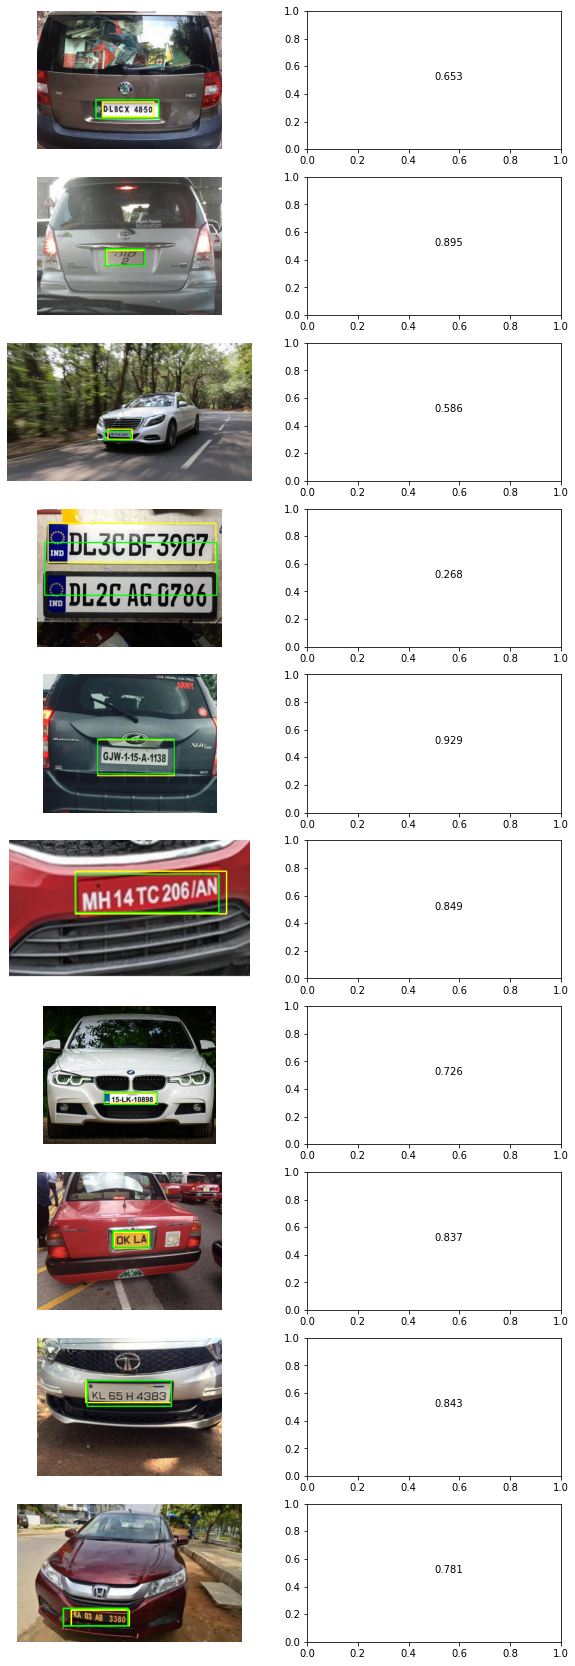

In [74]:
fig,ax = plt.subplots(10,2,figsize=(10,30))
for i in range(10):
    image = plt.imread(info['url'][i])
    gt = info['gt'][i]
    pd = info['pd'][i]
    img = cv2.rectangle(image,(gt[0],gt[2]),(gt[1],gt[3]),(255,255,0),2)
    img = cv2.rectangle(img,(pd[0],pd[2]),(pd[1],pd[3]),(0,255,0),2)
    ax[i,0].axis('off')
    ax[i,0].imshow(img)
    ax[i,1].text(0.5,0.5,np.round_(info['iou'][i],3))
#     print(info['iou'][i])
    
    

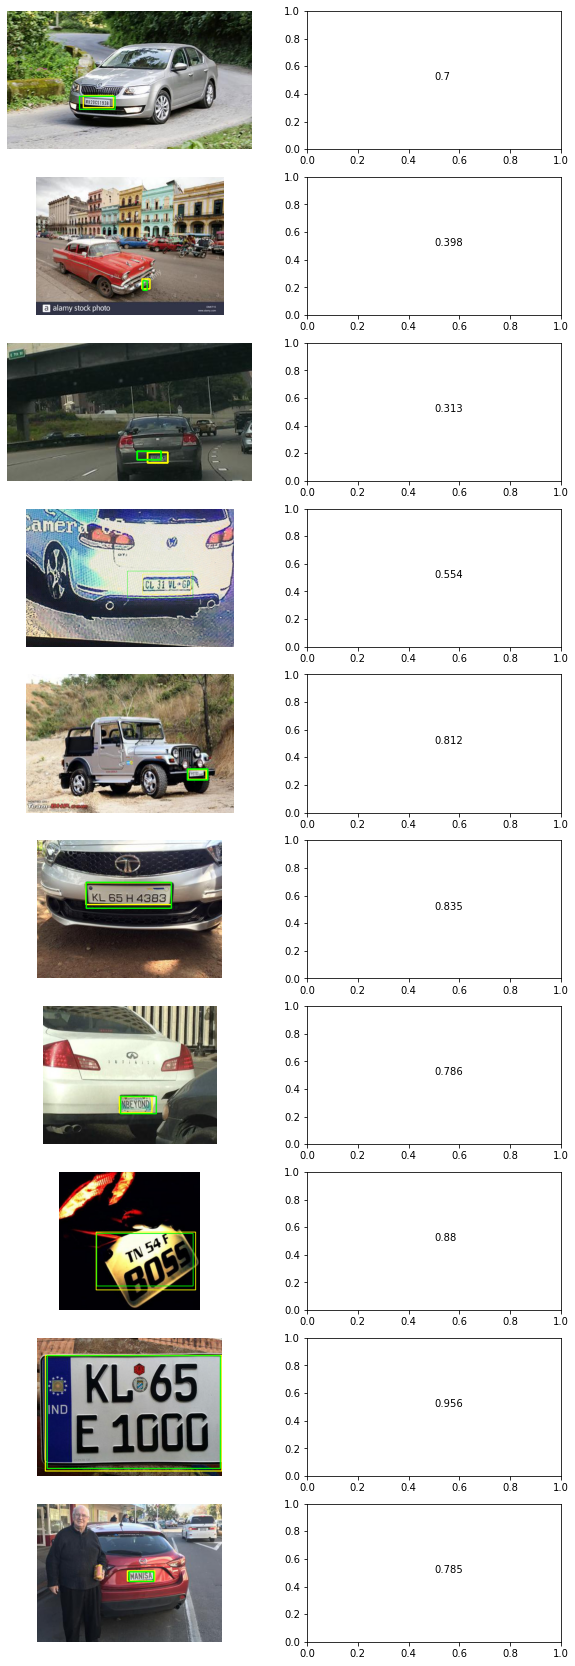

In [40]:
fig,ax = plt.subplots(10,2,figsize=(10,30))
for i in range(10):
    image = plt.imread(info['url'][i])
    gt = info['gt'][i]
    pd = info['pd'][i]
    img = cv2.rectangle(image,(gt[0],gt[2]),(gt[1],gt[3]),(255,255,0),2)
    img = cv2.rectangle(img,(pd[0],pd[2]),(pd[1],pd[3]),(0,255,0),2)
    ax[i,0].axis('off')
    ax[i,0].imshow(img)
    ax[i,1].text(0.5,0.5,np.round_(info['iou'][i],3))
#     print(info['iou'][i])
    
    

### Calculate the mAP Score of the models prediction on the whole image dataset

In [84]:
xmls = glob.glob('./VOC2007/Annotations/*.xml')
pred_info={}
ground_info={}

In [85]:
for xml in xmls:
    img_url = xml.replace('Annotations','JPEGImages').replace('xml','jpg')
    img_name = img_url.split('/')[-1]
    h,w = plt.imread(img_url).shape[:2]
    preprocessed_img = preprocessImage(img_url)
    pred = model.predict(np.expand_dims(preprocessed_img,axis=0))
    pred = pred * ([w,w,h,h])
    pred = np.squeeze(pred)
    pred_info[img_name] = [int(x) for x in pred]
    grnd = getcoordinate(xml)
    ground_info[img_name] = [x for x in grnd[1]]
    

2022-08-08 23:08:44.799730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 103ms/step


In [86]:
pred_info

{'car_499.jpg': [228, 278, 184, 210],
 'car_328.jpg': [267, 320, 168, 192],
 'car_314.jpg': [229, 311, 153, 184],
 'car_472.jpg': [146, 249, 145, 168],
 'car_466.jpg': [230, 272, 156, 175],
 'car_300.jpg': [46, 86, 202, 231],
 'car_658.jpg': [93, 122, 163, 181],
 'car_116.jpg': [126, 509, 128, 312],
 'car_102.jpg': [126, 364, 105, 189],
 'car_664.jpg': [227, 379, 191, 230],
 'car_48.jpg': [373, 1002, 278, 570],
 'car_74.jpg': [164, 336, 166, 223],
 'car_60.jpg': [782, 1117, 752, 857],
 'car_248.jpg': [130, 277, 198, 241],
 'car_260.jpg': [140, 220, 173, 210],
 'car_506.jpg': [105, 146, 196, 219],
 'car_512.jpg': [92, 162, 146, 168],
 'car_274.jpg': [145, 248, 114, 161],
 'car_513.jpg': [114, 274, 118, 153],
 'car_275.jpg': [168, 238, 194, 232],
 'car_261.jpg': [163, 240, 202, 224],
 'car_507.jpg': [77, 147, 164, 189],
 'car_249.jpg': [124, 278, 82, 116],
 'car_61.jpg': [124, 289, 199, 264],
 'car_75.jpg': [424, 519, 144, 185],
 'car_49.jpg': [101, 211, 186, 250],
 'car_103.jpg': [300, 

In [87]:
ground_info

{'car_499.jpg': [243, 285, 184, 204],
 'car_328.jpg': [269, 317, 170, 189],
 'car_314.jpg': [229, 309, 151, 178],
 'car_472.jpg': [152, 247, 145, 167],
 'car_466.jpg': [253, 284, 163, 177],
 'car_300.jpg': [54, 90, 201, 226],
 'car_658.jpg': [95, 127, 162, 182],
 'car_116.jpg': [114, 522, 126, 325],
 'car_102.jpg': [128, 361, 73, 201],
 'car_664.jpg': [236, 375, 193, 228],
 'car_48.jpg': [312, 1125, 291, 530],
 'car_74.jpg': [159, 343, 162, 225],
 'car_60.jpg': [769, 1121, 725, 844],
 'car_248.jpg': [131, 273, 206, 234],
 'car_260.jpg': [143, 213, 172, 211],
 'car_506.jpg': [109, 147, 199, 217],
 'car_512.jpg': [99, 162, 149, 167],
 'car_274.jpg': [146, 246, 113, 162],
 'car_513.jpg': [114, 276, 116, 156],
 'car_275.jpg': [168, 240, 195, 230],
 'car_261.jpg': [167, 240, 202, 220],
 'car_507.jpg': [75, 125, 173, 195],
 'car_249.jpg': [122, 277, 82, 117],
 'car_61.jpg': [122, 290, 208, 260],
 'car_75.jpg': [412, 519, 143, 185],
 'car_49.jpg': [114, 206, 196, 240],
 'car_103.jpg': [299, 2

In [88]:
import json
    
with open("pred_info.json", "w") as outfile:
    json.dump(pred_info, outfile)
    outfile.close()
    
with open("ground_info.json", "w") as outfile:
    json.dump(ground_info, outfile)
    outfile.close()

In [89]:
get_map_score(pred_info,ground_info)

0.6901752955564614